# UCDPA - Introduction to Data Analytics
# Project: 2023 LoL Worlds Winner Prediction

In [1]:
"""
    Import Packages
"""

#mathematical
import pandas as pd
import numpy as np

#API
import mwclient
from tqdm.notebook import tqdm

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [259]:
"""
    Graph Settings
"""
region_colours = {"KR":"royalblue", "CN":"red", "EMEA":"orange", "NA":"green", \
               "BR":"yellow", "INT":"black","JP":"pink","LAT":"lime","PCS":"aqua","VN":"violet"}

#

## Shortcut

In [ ]:
# ===== Shortcut - Import df_Scoreboard ===== #
df_Scoreboard = pd.read_csv("Scoreboard.csv")
df_Scoreboard.head()

#save as csv
df_Scoreboard.to_csv("Scoreboard.csv", index=False)

#

# Import Scoreboard data from Leaguepedia through API

## API full set of Scoreboard data with: 

In [220]:
"""
    Import Scoreboard Games data from Leaguepedia
    For all leagues
    Get detailed information
"""
site = mwclient.Site('lol.fandom.com', path='/')

leagues = ["GPL", "IWCQ", "WCS", "LCS", "LEC", "LCK", "LPL", "CBLOL", "LCL", "LJL", "LLA", "OPL", "PCS", "VCS", "TCL", "LMS", "LST", "NA LCS", "EU LCS", "LLN", "CLS"]
results = []

for league in tqdm(leagues):
    off=0
    
    while True:
    
        response = site.api("cargoquery",
                            offset=str(off),
                            
                            limit="max",
                            
                            tables = "ScoreboardGames=SG,Tournaments=T, Leagues=L",
                            
                            fields="T.Name=Tournament,\
                            L.League_Short=League,\
                            SG.DateTime_UTC=Date, SG.Team1, SG.Team2, SG.WinTeam, \
                            SG.Team1Kills, SG.Team2Kills, SG.Team1Gold , SG.Team2Gold, SG.Team1Dragons, SG.Team2Dragons, \
                            SG.Team1Barons, SG.Team2Barons, SG.Team1RiftHeralds, SG.Team2RiftHeralds, SG.Team1Towers, SG.Team2Towers, \
                            SG.Team1Inhibitors, SG.Team2Inhibitors",

                            where = 'L.League_Short = "'+league+'"',
                            
                            join_on = "SG.OverviewPage=T.OverviewPage, T.League = L.League")
    
        results += response["cargoquery"] 
        
        off=off+500
        if(len(response["cargoquery"])<500): break

  0%|          | 0/21 [00:00<?, ?it/s]

In [221]:
"""
    Convert results into DataFrame and clean
"""
df_Scoreboard = pd.DataFrame([ a["title"] for a in results ])

df_Scoreboard = df_Scoreboard.drop("Date__precision", axis=1)
df_Scoreboard.sort_values(by = "Date",inplace=True)

df_Scoreboard["Date"] = pd.to_datetime(df_Scoreboard["Date"])
df_Scoreboard["Year"]= df_Scoreboard["Date"].dt.year

# 

## API full set of Teams Region data with: 

In [222]:
"""
    Import Teams and Region data from Leaguepedia
    For all leagues
    Get detailed information
"""
site = mwclient.Site("lol.fandom.com", path='/')

leagues = ["GPL", "IWCQ", "WCS", "LCS", "LEC", "LCK", "LPL", "CBLOL", "LCL", "LJL", "LLA", "OPL", "PCS", "VCS", "TCL", "LMS", "LST", "NA LCS", "EU LCS", "LLN", "CLS"]

results = []

for league in tqdm(leagues):
    off=0
    
    while True:

        response = site.api("cargoquery",
                            offset=str(off),
                            
                            limit="max",
                            
                            tables = "Teams=T",
                            
                            fields="T.Name=Team, T.Region=Region, T.Short=Team_abbr")
                            
        results += response["cargoquery"] 
        
        off=off+500
        if(len(response["cargoquery"])<500): break

  0%|          | 0/21 [00:00<?, ?it/s]

In [223]:
"""
    Convert results into DataFrame and clean
"""
df_TeamRegion = pd.DataFrame([ a["title"] for a in results ])

df_TeamRegion = df_TeamRegion.dropna()
df_TeamRegion = df_TeamRegion.drop_duplicates(subset="Team")

In [224]:
"""
    Add DAMWON Gaming and DWG KIA to df_Team_Region:
    because they are Worlds Winners of 2020, 2021 
    They both renamed => DK
"""

df_TeamRegion2 = {"Team":"DAMWON Gaming",
                  "Region":"Korea",
                  "Team_abbr":"DK"}

df_TeamRegion3 = {"Team":"DWG KIA",
                  "Region":"Korea",
                  "Team_abbr":"DK"}

df_TeamRegion = df_TeamRegion.append([df_TeamRegion2,df_TeamRegion3], ignore_index=True)

C:\Users\vivia\AppData\Local\Temp\ipykernel_7324\3815273305.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_TeamRegion = df_TeamRegion.append([df_TeamRegion2,df_TeamRegion3], ignore_index=True)


In [225]:
"""
    Some teams cannot be matched to regions because they have renamed
    I created a csv matching the old team names to new team names
    Which are then merged together
"""

df_OldtoNewTeams = pd.read_csv("OldtoNewTeams.csv")

df_TeamRegion = pd.concat([df_TeamRegion,df_OldtoNewTeams])
df_TeamRegion.to_csv("TeamRegion.csv",index=False)

In [225]:
"""
    Some regions have merged together with others historically
    This information cannot be found on Leaguepedia
    I created a csv matching the correct regions to their abbreviations
    Which are then merged together
"""

df_Region_code = pd.read_csv("Region_Code.csv",na_filter = False) #interprets NA as string instead of NaN value

df_TeamRegion_code = df_TeamRegion.merge(df_Region_code, on = 'Region', how = 'left')
df_TeamRegion_code.drop(columns=["Region"], inplace = True)

NameError: name 'df_TeamRegion' is not defined

In [227]:
"""
    SK Telecom T1 has renamed to T1
    This is important as they played and won many matches which can affect the analysis
    Therefore I replaced the code for SK Telecom T1 to T1
"""

df_TeamRegion_code = df_TeamRegion_code.replace(to_replace = "SKT", value = "T1")
df_TeamRegion_code.to_csv("TeamRegion.csv", index=False)

#

## Merge Scoreboard and TeamRegion to get:
- Team1, Team2, WinTeam Regions
- blue/red side

## Add Region and Region Code to Scoreboard

In [229]:
"""
    Merging Region codes with Scoreboard Games data
    So I can find out which teams are from which regions
    (This helps looking at which regions have participated and won the most matches)
"""

df_Scoreboard = df_Scoreboard.merge(df_TeamRegion_code, left_on = 'Team1', right_on = 'Team', how = 'left')

df_Scoreboard = df_team1.merge(df_TeamRegion_code, left_on = 'Team2', right_on = 'Team', how = 'left')

df_Scoreboard = df_team1and2.merge(df_TeamRegion_code, left_on = 'WinTeam', right_on = 'Team', how = 'left')

df_Scoreboard.drop(columns=["Team_x","Team_y","Team"], inplace = True)
df_Scoreboard.rename(columns={'Region_x':'Region_T1','Team_abbr_x':'Team_T1','Region_code_x':'Region_code_T1','Region_y':'Region_T2','Team_abbr_y':'Team_T2','Region_code_y':'Region_code_T2','Region':'Region_Win','Team_abbr':'Team_Win','Region_code':'Region_code_Win'},inplace=True)

## Add Blue/Red Side to Scoreboard

In [230]:
"""
    Add a column to Scoreboard Games data: Blue/Red
    Leaguepedia states that Team1 is on blue side and Team2 is on red side
    So I created a for loop to differentiate between blue and red side
"""

#get if blue side or red side is winner
for lab, row in df_Scoreboard.iterrows():
    if row["Team1"] == row["WinTeam"]:
        df_Scoreboard.loc[lab,"Blue/Red"] = "Blue"
    else:
        df_Scoreboard.loc[lab,"Blue/Red"] = "Red"

df_Scoreboard[["Region_code_T1", "Region_code_T2","Region_code_Win"]] = df_Scoreboard[["Region_code_T1", "Region_code_T2","Region_code_Win"]].fillna("NA")

,Tournament,League,Date,Team1,Team2,WinTeam,Team1Kills,Team2Kills,Team1Gold,Team2Gold,...,Team1Inhibitors,Team2Inhibitors,Year,Team_T1,Region_code_T1,Team_T2,Region_code_T2,Team_Win,Region_code_Win,Blue/Red
0,Worlds Season 1,WCS,2011-06-18 08:30:00,against All authority,Epik Gamer,Epik Gamer,None,None,None,None,...,None,None,2011,aAa,EMEA,EPIK,NA,EPIK,NA,Red
1,Worlds Season 1,WCS,2011-06-18 09:45:00,Fnatic,Team Pacific,Fnatic,None,None,None,None,...,None,None,2011,FNC,EMEA,PCFC,PCS,FNC,EMEA,Blue
2,Worlds Season 1,WCS,2011-06-18 11:00:00,Epik Gamer,Team Pacific,Epik Gamer,None,None,None,None,...,None,None,2011,EPIK,NA,PCFC,PCS,EPIK,NA,Blue
3,Worlds Season 1,WCS,2011-06-18 11:00:00,against All authority,Fnatic,against All authority,None,None,None,None,...,None,None,2011,aAa,EMEA,FNC,EMEA,aAa,EMEA,Blue
4,Worlds Season 1,WCS,2011-06-18 12:15:00,against All authority,Team Pacific,against All authority,None,None,None,None,...,None,None,2011,aAa,EMEA,PCFC,PCS,aAa,EMEA,Blue


In [18]:
#replace SKT to T1
df_Scoreboard = df_Scoreboard.replace(to_replace = "SKT", value = "T1")
df_Scoreboard.to_csv("Scoreboard.csv", index=False)

#

# Worlds Winners 2011 - 2022

## Get Worlds Tournament only - original dataset contains regional finals

In [122]:
"""
    LoL Worlds Winners Analysis 2011 - 2022
    Leagues labeled WCS include regional finals
    Must filter Tournaments that start with "Worlds"
"""

df_Scoreboard_Worlds = df_Scoreboard[df_Scoreboard["Tournament"].str.startswith("Worlds")]
df_Scoreboard_Worlds = df_Scoreboard_Worlds.reset_index(drop=True)
df_Scoreboard_Worlds = df_Scoreboard_Worlds.drop_duplicates(keep="first")

## Graph - Top 10 Team Winners in ALL matches of Worlds

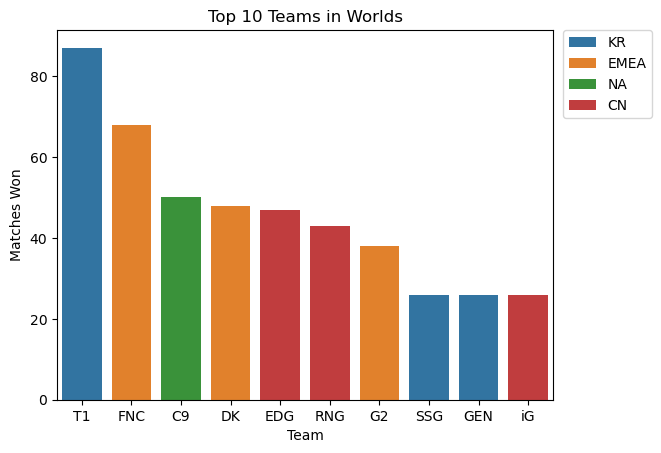

In [331]:
top_10_Worlds_teams = pd.DataFrame((df_Scoreboard_Worlds["Team_Win"].value_counts()).iloc[:10]).reset_index()
top_10_Worlds_teams = top_10_Worlds_teams.rename(columns={top_10_Worlds_teams.columns[0]:"Team","Team_Win":"Matches Won"})
top_10_Worlds_teams = top_10_Worlds_teams.merge(df_TeamRegion_code, left_on = "Team", right_on = "Team_abbr", how = "left" )
top_10_Worlds_teams = top_10_Worlds_teams.drop(columns = ["Team_y","Team_abbr"])
top_10_Worlds_teams = top_10_Worlds_teams.drop_duplicates(subset="Team_x")
top_10_Worlds_teams = top_10_Worlds_teams.rename(columns={"Team_x":"Team"})

hue_order = ["KR","EMEA","NA","CN"]
sns.barplot(x = "Team", y = "Matches Won", data = top_10_Worlds_teams ,hue = "Region_code", hue_order = hue_order, dodge = False)\
    .set(title="Top 10 Teams in Worlds")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## Graph - Top 10 Region Winners in ALL matches of Worlds

[Text(0.5, 1.0, 'Top 10 Regions in Worlds')]

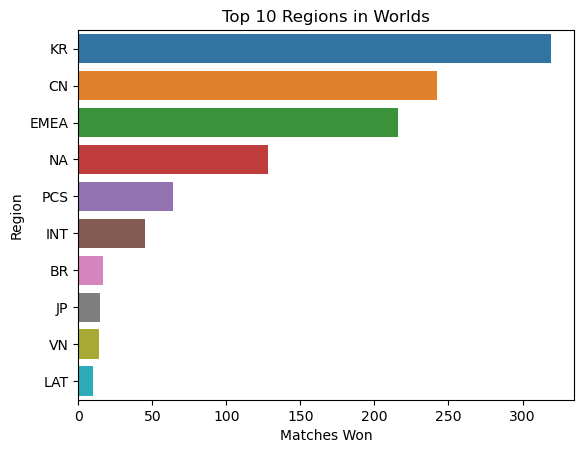

In [124]:
top_10_Worlds_regions = pd.DataFrame((df_Scoreboard_Worlds['Region_code_Win'].value_counts()).iloc[:10]).reset_index()
top_10_Worlds_regions = top_10_Worlds_regions.rename(columns = {top_10_Worlds_regions.columns[0]:"Region","Region_code_Win":"Matches Won"})

sns.barplot(x = "Matches Won", y = "Region", data = top_10_Worlds_regions, orient = "h").set(title="Top 10 Regions in Worlds")

## Get list of all World Winners - filter who won most matches in Finals

In [128]:
"""
    Create function to get winner of each year for Worlds
"""

def get_winner(year):
    finals_year = df_Scoreboard_Worlds[df_Scoreboard_Worlds["Year"]==year]
    winner = finals_year["WinTeam"].value_counts( ).idxmax()
    return winner

years = [i for i in range(2011,2023)]
winners = []

for i in range(2011,2023):
    winners.append(get_winner(i))

dict_worlds_winners = {}
for i in range(len(years)):
    dict_worlds_winners[years[i]] = winners[i]

## Graph - Frequency of Worlds Winner : Teams 

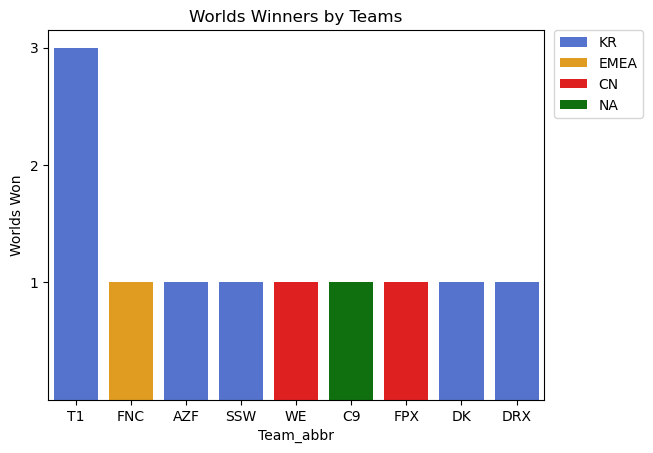

In [330]:
df_worlds_winners = pd.DataFrame(data = [dict_worlds_winners])
df_worlds_winners = df_worlds_winners.transpose()
df_worlds_winners.reset_index(inplace=True)
df_worlds_winners.columns = ["Year","Winner"]

df_worlds_winners = pd.DataFrame(df_worlds_winners["Winner"].value_counts())
df_worlds_winners = df_worlds_winners.rename(columns = {"Winner":"Worlds Won"})
df_worlds_winners = df_worlds_winners.reset_index()
df_worlds_winners = df_worlds_winners.rename(columns = {df_worlds_winners.columns[0]:"Team"})
df_worlds_winners = df_worlds_winners.merge(df_TeamRegion_code, on = "Team", how = "left")
df_worlds_winners

sns.barplot(x = "Team_abbr", y = "Worlds Won", data = df_worlds_winners ,hue = "Region_code", palette = region_colours , dodge = False).set(title="Worlds Winners by Teams")
plt.yticks([1,2,3])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## Graph - Frequency of Worlds Winner : Regions 

[Text(0.5, 1.0, 'Worlds Winners by Region')]

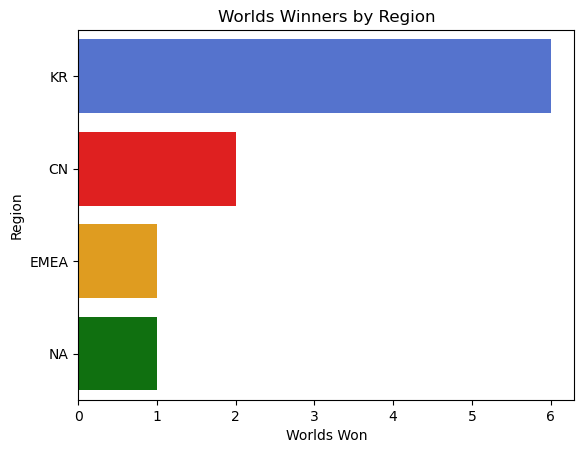

In [329]:
df_worlds_winners_regions = pd.DataFrame(df_worlds_winners["Region_code"].value_counts())
df_worlds_winners_regions = df_worlds_winners_regions.reset_index()
df_worlds_winners_regions = df_worlds_winners_regions.rename(columns={df_worlds_winners_regions.columns[0]:"Region",
                                                                     df_worlds_winners_regions.columns[1]:"Worlds Won"})
sns.barplot(x =  "Worlds Won", y = "Region", data = df_worlds_winners_regions, palette = region_colours, orient = "h") \
    .set(title="Worlds Winners by Region")

## Get Participation of Regions in Worlds
- to show that Korea participated later but won a lot more matches/worlds finals


## Group by years and find out region participation

In [214]:
"""
    Group Team1 and Team2 together 
    Get Participation Counts (how many times each time has played a match)
    Convert to DataFrame
    Clean DataFrame
"""

data1 = df_Scoreboard_Worlds.groupby(["Year","Region_code_T1"])["Region_code_T1"].count()
data2 = df_Scoreboard_Worlds.groupby(["Year","Region_code_T2"])["Region_code_T2"].count()
df_participation = pd.DataFrame(pd.concat([data1,data2],axis=1))

df_participation["Region_T1_T2"]=df_participation["Region_code_T1"] + df_participation["Region_code_T2"] 
df_participation= df_participation.reset_index()
df_participation.rename(columns={df_participation.columns[1]:"Region",df_participation.columns[4]:"Participation_counts"},inplace=True)

df_participation = pd.DataFrame(df_participation.groupby(["Year","Region"])["Participation_counts"].sum())

Participation_counts
Year Region                      
2011 EMEA                    28.0
     NA                      22.0
     PCS                      0.0
2012 CN                       8.0
     EMEA                    12.0
...                           ...
2022 KR                      72.0
     LAT                      5.0
     NA                      28.0
     PCS                     16.0
     VN                      15.0

[93 rows x 1 columns]

In [217]:
"""
    Get Win Counts
    Compare Participation Counts vs Win Counts
    Get Ratio for 'Win Rate %'
"""
dfwins = pd.DataFrame(df_Scoreboard_Worlds.groupby(["Year","Region_code_Win"])["Region_code_Win"].count())
dfwins.rename(columns={"Region_code_Win":"Win_counts"},inplace=True)
dfwins = dfwins.reset_index()
dfwins.rename(columns={"Region_code_Win":"Region"},inplace=True)

dfcompare_part_wins = dfwins.merge(df_participation, on = ["Year","Region"], how = "left")
dfcompare_part_wins = dfcompare_part_wins.set_index(["Region","Year"])

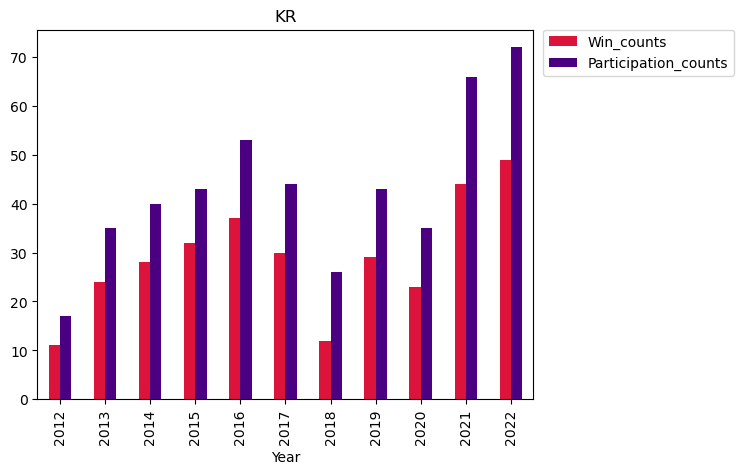

In [327]:
"""
    Graph for Partcipation to Win Ratio
"""
def graph_part_win_counts(region):
    dfcompare_part_wins.loc[region].plot(kind="bar", title=region, color = ["crimson","indigo"])

graph_part_win_counts("KR")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [227]:
"""
    Create a table that shows Win Rate% per region
"""
list_regions = list(df_Region_code["Region_code"].unique())

def get_part_win_ratio(region): 
    part_wins_ratio = dfcompare_part_wins.loc[region]["Win_counts"]/dfcompare_part_wins.loc[region]["Participation_counts"]
    return 100*part_wins_ratio.mean()

df_ratios = pd.DataFrame()
df_ratios["Regions"] = list_regions
df_ratios["Win Rate %"] = df_ratios["Regions"].apply(get_part_win_ratio)

#correct for PCS - inf
df_part_wins_ratio_PCS = dfcompare_part_wins.loc["PCS"]["Win_counts"]/dfcompare_part_wins.loc["PCS"]["Participation_counts"]
df_part_wins_ratio_PCS.replace([np.inf, -np.inf], np.nan, inplace=True)
df_part_wins_ratio_PCS.dropna(inplace=True)
df_ratios.at[8,"Win Rate %"] = df_part_wins_ratio_PCS.mean()

df_ratios = df_ratios.sort_values("Win Rate %",ascending = False)
df_ratios

,Regions,Win Rate %
5,KR,66.338297
2,CN,55.865905
0,EMEA,46.548568
7,NA,41.285467
3,INT,34.337217
4,JP,31.272727
9,VN,29.285714
6,LAT,27.214286
1,BR,25.925926
8,PCS,0.354104


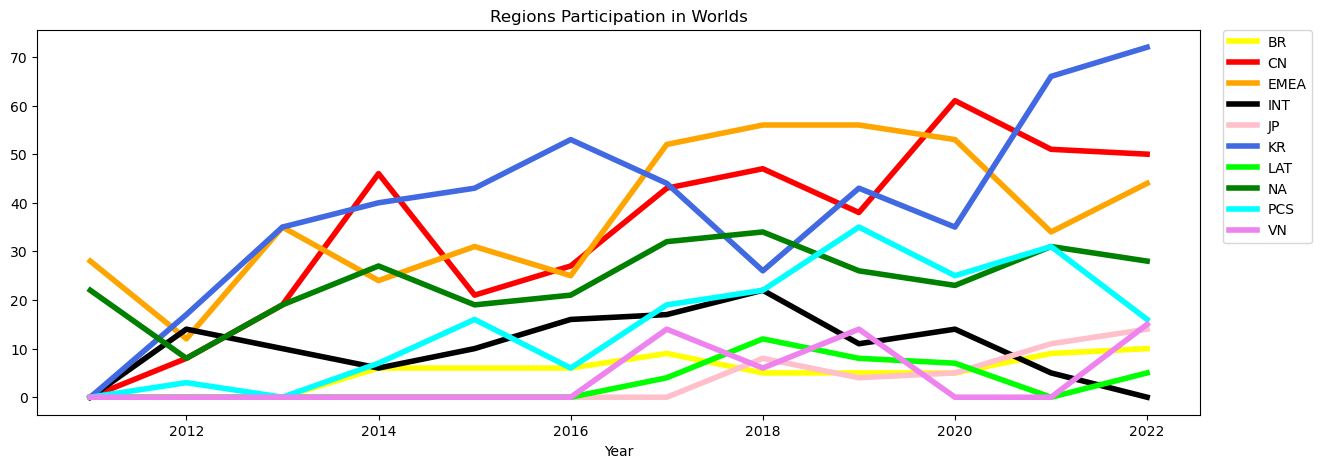

In [326]:
"""
    Graph - Regional Participation in Worlds
    How many matches does each Region play in Worlds 
"""

piv_participation_finals = pd.pivot_table(dfcompare_part_wins, index="Year",columns="Region",values="Participation_counts", fill_value=0)
piv_participation_finals

piv_participation_finals.plot(title = "Regions Participation in Worlds", linewidth = 4, figsize = (15,5), color = region_colours)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## KR and CN has wr% > 50% and EMEA has close to wr% 47%
## From Graph -  can see these 3 regions has most teams entered and playing in Worlds

## Decide to only look at KR, CN, EMEA as a result of analysis:
- Worlds Winners region frequency
- Match winners region frequency
- Participation counts region frequency

# 

## Get KR, CN and EMEA top x teams to qualify to Swiss Round
- Get top x teams to qualify to Swiss Round by Win-to-Participation Ratio (where teams have played > y matches)
- KR(LCK) has 4 teams qualifying, CN(LPL) 4, EMEA(LEC) 3

In [344]:
def get_top_x_teams_league(league,x, y=100):
    
    df_Scoreboard_TL = df_Scoreboard[df_Scoreboard["League"]==league]


    teams_wins = df_Scoreboard_TL.groupby(["Team_Win"])["Team_Win"].count()
    teams_wins.name="Win_Counts"
    df_teams_wins = pd.DataFrame(teams_wins).reset_index()
    df_teams_wins.rename(columns={"Team_Win":"Team"},inplace=True)


    teams_T1 =  df_Scoreboard_TL.groupby(["Team_T1"])["Team_T1"].count()
    teams_T2 = df_Scoreboard_TL.groupby(["Team_T2"])["Team_T2"].count()
    df_teams_part = pd.DataFrame(pd.concat([teams_T1,teams_T2],axis=1))
    df_teams_part["Participation_Counts"]=df_teams_part["Team_T1"] + df_teams_part["Team_T2"] 
    df_teams_part = df_teams_part.drop(columns=["Team_T1","Team_T2"]).reset_index()
    df_teams_part.rename(columns={df_teams_part.columns[0]:"Team"},inplace=True)


    teams = df_teams_part.merge(df_teams_wins, on = "Team", how = "left")
    teams = teams[teams["Participation_Counts"]>y] #count only teams who have played more than 100 matches
    teams["Ratio"] = (teams["Win_Counts"]/teams["Participation_Counts"]*100).round(1).astype(str) + '%'
    teams = teams.sort_values("Ratio",ascending=False)


    return teams[0:x]

In [345]:
get_top_x_teams_league("LPL",10,100)

,Team,Participation_Counts,Win_Counts,Ratio
6,EDG,906,593.0,65.5%
36,TES,411,262.0,63.7%
29,RNG,784,479.0,61.1%
13,JDG,580,351.0,60.5%
41,WBG,147,85.0,57.8%
9,FPX,526,299.0,56.8%
49,iG,903,494.0,54.7%
34,SN,400,210.0,52.5%
3,BLG,524,270.0,51.5%
42,WE,922,473.0,51.3%


In [346]:
def get_top_x_teams_global(x, y=100):
    
    df_Scoreboard_TL = df_Scoreboard


    teams_wins = df_Scoreboard_TL.groupby(["Team_Win"])["Team_Win"].count()
    teams_wins.name="Win_Counts"
    df_teams_wins = pd.DataFrame(teams_wins).reset_index()
    df_teams_wins.rename(columns={"Team_Win":"Team"},inplace=True)


    teams_T1 =  df_Scoreboard_TL.groupby(["Team_T1"])["Team_T1"].count()
    teams_T2 = df_Scoreboard_TL.groupby(["Team_T2"])["Team_T2"].count()
    df_teams_part = pd.DataFrame(pd.concat([teams_T1,teams_T2],axis=1))
    df_teams_part["Participation_Counts"]=df_teams_part["Team_T1"] + df_teams_part["Team_T2"] 
    df_teams_part = df_teams_part.drop(columns=["Team_T1","Team_T2"]).reset_index()
    df_teams_part.rename(columns={df_teams_part.columns[0]:"Team"},inplace=True)


    teams = df_teams_part.merge(df_teams_wins, on = "Team", how = "left")
    teams = teams[teams["Participation_Counts"]>y] #count only teams who have played more than 100 matches
    teams["Ratio"] = (teams["Win_Counts"]/teams["Participation_Counts"]*100).round(1).astype(str) + '%'
    teams = teams.sort_values("Ratio",ascending=False)


    return teams[0:x]

In [347]:
get_top_x_teams_global(10,500)

,Team,Participation_Counts,Win_Counts,Ratio
402,T1,907.0,601.0,66.3%
171,G2,581.0,385.0,66.3%
110,DK,518.0,343.0,66.2%
127,EDG,1016.0,656.0,64.6%
63,C9,809.0,520.0,64.3%
487,ahq,536.0,337.0,62.9%
179,GEN,562.0,353.0,62.8%
159,FNC,809.0,495.0,61.2%
352,RNG,871.0,530.0,60.8%
228,JDG,614.0,370.0,60.3%


#

# Model with Factor Rating: Find relationship between
- KDA (.Team1Kills,.Team2Kills)
- Barons/Dragons (.Team1Dragons, .Team2Dragons, .Team1Barons , .Team2Barons )
- RiftHeralds: .Team1RiftHeralds .Team2RiftHeralds 
-  Inhibitors: .Team1Inhibitors  .Team2Inhibitors 
- Gold Lead: .Team1Gold .Team2Gold 
- Towers: .Team1Towers .Team2Towers 

In [263]:
df_Scoreboard.replace('  ', np.nan, inplace=True)
df_Scoreboard_factors = df_Scoreboard.dropna()

## Blue/Red Side

In [264]:
"""
    Find out if blue or red side wins more
    Blue side has a slightly higher win rate (considering a 50% change getting blue or red)
"""

df_Scoreboard_factors_BR = df_Scoreboard_factors.groupby(["Blue/Red"])["Blue/Red"].count()

df_Scoreboard_factors_BR["blue %"] = 100*df_Scoreboard_factors_BR.iloc[0]/df_Scoreboard_factors_BR.sum()
df_Scoreboard_factors_BR["red %"] = 100*df_Scoreboard_factors_BR.iloc[1]/df_Scoreboard_factors_BR.sum()
df_Scoreboard_factors_BR

Blue/Red
Blue      17317.000000
Red       14826.000000
blue %       53.874872
red %        46.047947
Name: Blue/Red, dtype: float64

## Gold Lead, Kills ,Barons, Dragons, RiftHeralds, Towers, Inhibitors

In [267]:
"""
    Create a function that would add columns for each factor for winning and losing team
    Next step is summary stats for each factor to select which ones are significant
"""

df_Scoreboard_factors = df_Scoreboard_factors.astype({'Team1Gold':'int','Team2Gold':'int',})

factors = {"Gold","Kills","Barons","Dragons","RiftHeralds","Towers","Inhibitors"}

for i in factors:
    if i == "Gold":
        for lab, row in df_Scoreboard_factors.iterrows():
            if row["Team1"] == row["WinTeam"]:
                df_Scoreboard_factors.loc[lab,"Win_GoldLead"] = df_Scoreboard_factors.loc[lab,"Team1Gold"] - df_Scoreboard_factors.loc[lab,"Team2Gold"] 
            else:
                df_Scoreboard_factors.loc[lab,"Win_GoldLead"] = df_Scoreboard_factors.loc[lab,"Team2Gold"] - df_Scoreboard_factors.loc[lab,"Team1Gold"] 
    else:
        for lab, row in df_Scoreboard_factors.iterrows():
            if row["Team1"] == row["WinTeam"]:
                df_Scoreboard_factors.loc[lab,"Win_"+i] = df_Scoreboard_factors.loc[lab,"Team1"+i] 
                df_Scoreboard_factors.loc[lab,"Lose_"+i] = df_Scoreboard_factors.loc[lab,"Team2"+i] 
            else:
                df_Scoreboard_factors.loc[lab,"Win_"+i] = df_Scoreboard_factors.loc[lab,"Team2"+i] 
                df_Scoreboard_factors.loc[lab,"Lose_"+i] = df_Scoreboard_factors.loc[lab,"Team1"+i] 
                
df_Scoreboard_factors = df_Scoreboard_factors.astype({'Win_Kills':'int','Win_Barons':'int','Win_Dragons':'int','Win_Towers':'int'})

TypeError: unsupported operand type(s) for -: 'str' and 'str'

## Get summary statistics to form model

In [269]:
"""
    Summary Stats
"""
df_Scoreboard_factors_SS = df_Scoreboard_factors[["Win_Kills","Lose_Kills","Win_GoldLead","Win_Barons","Lose_Barons","Win_Dragons","Lose_Dragons", 
                      "Win_RiftHeralds","Lose_RiftHeralds","Win_Towers","Win_Inhibitors","Lose_Inhibitors"]].describe(include="all")
df_Scoreboard_factors_SS.astype(int)

#if kills = 11-17: 1pt
#if kills = 17-20: 2pts
#if kills > 20: 3pts

#if gold lead = 7701 ~ 10686: 1pts
#if gold lead = 10687 ~ 13414: 2pts
#if gold lead > 13414: 3pts

#seems like barons don't make much of a difference
#seems like rift heralds don't make much of a difference
#seems like inhibitors don't make much of a difference 

#if dragons = 2 - 3: 1pt
#if dragons = 4 : 2pts
#if dragons > 4 : 3pts

#not a huge differentiation but can see more more towers = more wins
#if towers = 8 - 9: 1pt
#if towers = 10 - 11: 2pts

,Win_Kills,Lose_Kills,Win_GoldLead,Win_Barons,Lose_Barons,Win_Dragons,Lose_Dragons,Win_RiftHeralds,Lose_RiftHeralds,Win_Towers,Win_Inhibitors,Lose_Inhibitors
count,13941,13941,13941,13941,13941,13941,13941,13941,13941,13941,13941,13941
mean,17,8,10351,1,0,2,1,0,0,9,1,0
std,5,5,4388,0,0,1,1,0,0,1,1,0
min,1,0,-12124,0,0,0,0,0,0,0,0,0
25%,13,4,7700,1,0,2,0,0,0,8,1,0
50%,17,7,10686,1,0,3,1,1,0,9,2,0
75%,20,11,13414,1,0,4,2,1,1,11,2,0
max,56,48,34489,5,6,8,7,2,2,11,16,13


In [270]:
"""
    Create function for TeamPoints model using factors selected
    Apply to each team
"""

def Win_Points(team):

    team_points = 0
    
    for lab, row in df_Scoreboard_factors.iterrows():
        if  df_Scoreboard_factors.loc[lab,"Team_Win"] == team:
            
            #Blue/Red Side
            if df_Scoreboard_factors.loc[lab,"Blue/Red"] == "Blue":
                team_points +=1
            
            #Kills
            if df_Scoreboard_factors.loc[lab,"Win_Kills"] >= 11 and df_Scoreboard_factors.loc[lab,"Win_Kills"] < 17:
                team_points +=1
            elif df_Scoreboard_factors.loc[lab,"Win_Kills"] >= 17 and df_Scoreboard_factors.loc[lab,"Win_Kills"] <= 20:
                team_points +=2
            elif df_Scoreboard_factors.loc[lab,"Win_Kills"] >20:
                team_points +=3
                
            #Gold Lead
            if df_Scoreboard_factors.loc[lab,"Win_GoldLead"] >= 7701  and df_Scoreboard_factors.loc[lab,"Win_GoldLead"] < 10686:
                team_points +=1
            elif df_Scoreboard_factors.loc[lab,"Win_GoldLead"] >= 10687 and df_Scoreboard_factors.loc[lab,"Win_GoldLead"] <= 13414:
                team_points +=2
            elif df_Scoreboard_factors.loc[lab,"Win_GoldLead"] >13414:
                team_points +=3
                
            #Dragons
            if df_Scoreboard_factors.loc[lab,"Win_Dragons"] >= 2  and df_Scoreboard_factors.loc[lab,"Win_Dragons"] <= 3:
                team_points +=1
            elif df_Scoreboard_factors.loc[lab,"Win_Dragons"] == 4:
                team_points +=2
            elif df_Scoreboard_factors.loc[lab,"Win_Dragons"] > 4:
                team_points +=3  
            
            #Towers
            if df_Scoreboard_factors.loc[lab,"Win_Towers"] >= 8  and df_Scoreboard_factors.loc[lab,"Win_Towers"] <= 9:
                team_points +=1
            elif df_Scoreboard_factors.loc[lab,"Win_Towers"] >= 10:
                team_points +=2

                
    #get total points            
    return team_points 

In [299]:
"""
    Create dictionary to match Teams with their TeamPoints
"""
top_leagues = ["T1","DK","KZ","GEN","EDG","TES","RNG","JDG","G2","MAD","FNC"]
dict_team_points = {"Team_abbr":top_leagues , "Points": []}

for league in top_leagues:
    w = Win_Points(league)
    dict_team_points["Points"].append(w)

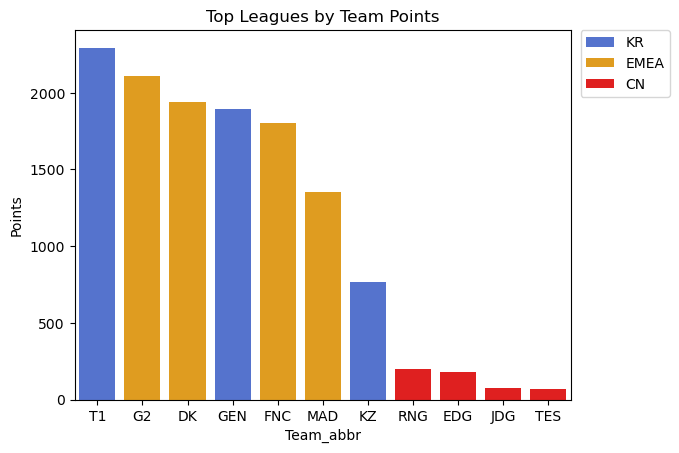

In [325]:
"""
    Graph - Plot Team Points for the Top Leagues (4KR,4CN,3EMEA)
"""
df_top_league_team_points = pd.DataFrame(dict_top_leagues_team_points).sort_values("Points",ascending=False)
df_top_league_team_points = df_top_league_team_points.merge(df_TeamRegion_code, on = "Team_abbr", how = "left")
df_top_league_team_points = df_top_league_team_points.drop_duplicates(subset="Team_abbr")

#MAD is code for many teams - but this team is MAD Lions
df_top_league_team_points.at[13,"Team"] = "MAD Lions"
df_top_league_team_points.at[13,"Region_code"] = "EMEA"

sns.barplot(x="Team_abbr" ,y= "Points", data = df_top_league_team_points, hue = "Region_code", 
            palette = region_colours, dodge = False).set_title("Top Leagues by Team Points")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [300]:
"""
    Apply to all teams in Scoreboard Games data with TeamPoints Model
"""
all_leagues = df_Scoreboard_factors["Team_T1"].unique()
df_all_team_points = {"Team":all_leagues , "Points": []}

for league in all_leagues:
    w = Win_Points(league)
    dict_team_points["Points"].append(w)
    
df_all_team_points = pd.DataFrame(dict_team_points).sort_values("Points",ascending=False)

KeyboardInterrupt: 

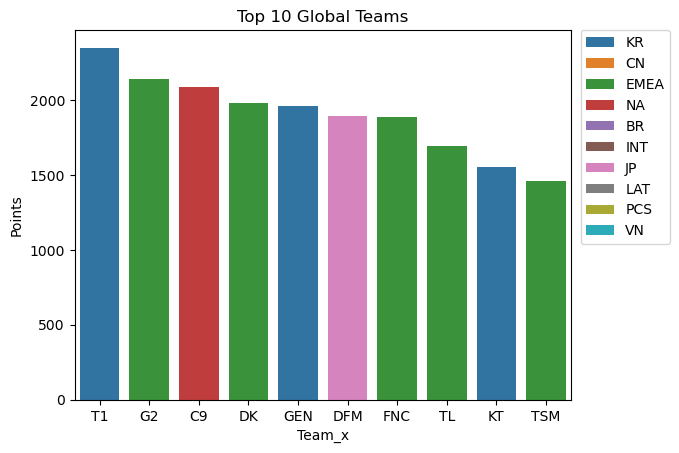

In [324]:
"""
    Graph - Top 10 Teams from ALL Leagues by TeamPoints
"""

df_all_team_points_region = df_all_team_points.merge(df_TeamRegion_code, left_on = "Team", right_on = "Team_abbr", how = "left")
df_all_team_points_region = df_all_team_points_region.drop_duplicates(subset = "Team_x")

top_10_team_points = df_all_team_points_region['Points'].iloc[:10]
top_10_team_points_region = df_all_team_points_region['Region_code'].iloc[:10]

sns.barplot(x = df_all_team_points_region["Team_x"].iloc[:10], y = df_all_team_points_region["Points"].iloc[:10], 
            hue = top_10_team_points_region, hue_order = region_colours, dodge = False).set(title='Top 10 Global Teams')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)